# Tutorial 2 - Disks with Elevated Emission Surfaces

This Notebook deals with disks where the vertical structure can clearly be resolved. This is fairly common now that ALMA observations of bright $^{12}{\rm CO}$ emission are routinely achieving angular resolutions of a few hundreds of milliarcseconds.

In [1]:
import matplotlib.pyplot as plt
from eddy import rotationmap

## HD 163296 - A Geometrically Thick Disk

For this tutorial we will look at the disk around HD 163296. We'll use data from the DSHARP project, with the data described in [Isella et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..49I/abstract) and available [here](https://bulk.cv.nrao.edu/almadata/lp/DSHARP/). There are many different ways of collapsing a cube to a velocity map and with various different programs. For now, we'll use ones collapsed using [`bettermoments`](https://bettermoments.readthedocs.io/en/latest) and are available from the [eddy Dataverse](https://dataverse.harvard.edu/dataverse/eddy).

Load up the data and inspect it.

Assuming uncertainties in ../../cubes/HD163296_CO_dv0.fits.


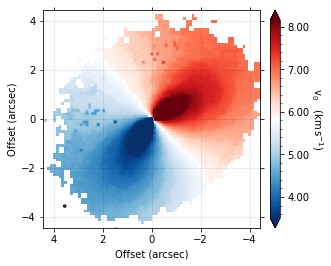

In [2]:
cube = rotationmap(path='../../cubes/HD163296_CO_v0.fits',
                   downsample='beam',
                   FOV=9.0)
cube.plot_data()

The vertical extent of a disk can be seen in the rotation map as the lobes of the dipole rotation pattern bend away from the disk major axis. This is very clear for the case of HD 163296. We can use the `plot_maxima` function which will find the line of maximum and minimum velocities along the red-shifted and blue-shifted major axes, respectively.

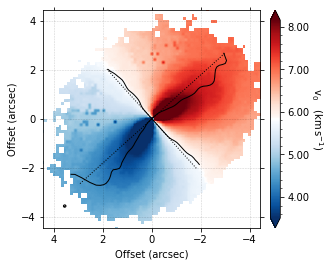

In [3]:
cube.plot_maxima(inc=46.7,PA=312.0, r_max=4.0, smooth=0.3)

In the above figure, the dotted lines show the major and minor axes of the disk based on the `inc` and `PA` values provided. The solid lines show the line of extreme velocities, showing that the emission surface is distinctly elevated. The `smooth` argument smooths the lines to beat down the jitter due to the noise.

This approach is also good for searching for signs of warps or strong radial flows where there should be a significant variation along the minor axis, as discused in [Rosenfeld et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...782...62R/abstract) or [Casassus et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...811...92C/abstract).

## Parameterising the Emission Height

We can go beyond the geometrically thin disk approximation and use a more realistic 3D structure. Here we assume an azimuthually symmetric emission surface parameterized by

$$z(r) = z_0 \times \left( \frac{r - r_{\rm cavity}}{1^{\prime\prime}}\right)^{\psi} \times \exp \left( -\left[ \frac{r_{\rm taper} - r_{\rm cavity}}{1^{\prime\prime}} \right]^{q_{\rm taper}}\right)$$

In this parameterization, $z_0$ is related to the aspect ratio of the emission surface, $\psi$ describes the flaring of this surface, $r_{\rm cavity}$ allows for an inner cavity, such as in a transition disk, and $\{r_{\rm taper},\, q_{\rm taper}\}$ descibe an exponential taper to model the drop in emission height at the edge of the disk. With this description we can recover the geometrically thin limit when $z_0 = 0$ and the conical surface discussed in [Rosenfeld et al. (2013)](https://ui.adsabs.harvard.edu/#abs/2013ApJ...774...16R) and used with [ConeRot](https://github.com/simoncasassus/ConeRot) with $z_0 > 0$, $\psi = 1$ and $r_{\rm taper} = \infty$.

---

**NOTE:** Previous versions of `eddy` used a double power law described by `z1` and `phi`. The large degeneracy between these parameters strongly favoured a move to this tapered approach (hat tip to Sean Andrews for the suggestion).

---

The coordinate transforms for geometrically thin disks or conical surface are purely analytical so are very quick. For the more complex surfaces this is a slower process. For monotonically increasing surface with a flaring value close to unity, this can be done in an iterative manner. This is the default in `eddy`, and the number of iterations used in the deprojection is set by the `cube.flared_niter` argument, defaulting to 5.

For the more complex surface, particularly those that are not monotonically increasing (i.e., those using the exponential tapered edge), this iterative approach fails ([see the `GoFish` documentation for an example](https://fishing.readthedocs.io/en/latest/user/fishing_coordinates.html#2.2-A-Complex-3D-Example)). To circumvent this, `eddy` has a slower, but more robust, approach to deprojecting the pixels, invoked with the `'shadowed'` parameter. This builds a 3D model of the emission surface which is then rotated and projected onto the sky.

#### Rotation Direction

Unlike for geometrically thin disks, we can now distinguish the rotation direction of the disk. In `eddy`, this information is encoded in the _sign_ of the inclination we define. We allow the inclination to run from $-90^{\circ}$ to $90^{\circ}$, with negative inclinations representing counter-clockwise rotation and positive inclinations described clockwise rotation. Again, the [`GoFish` documentation](https://fishing.readthedocs.io/en/latest/user/fishing_coordinates.html#3.1-Negative-Inclinations) has examples to demonstrate this.

One problem of this parameterization is that it is very hard for MCMC methods to jump between negative and positive values of inclination. **SOMETHING ABOUT GLOBAL MOVES**

#### Impact on Velocity Structure

The inclusion of a non-zero height will have two affects. Firstly, it will alter the deprojection which will have most significant difference along the semi-minor axis. Secondly, we have to correct $v_{\rm kep}$ for a) the additional distance to the star from an elevated location (difference in a radial polar coordinate and a radial cylindrical coordinate), and b) the projected gravitational force, resulting in,

$$v_{\rm kep} = \sqrt{\frac{GM_{\rm star}r^2}{(r^2 + z^2)^{3\,/\,2}}},$$

where $r$ is the cylindrical (or midplane) radius. Note that for the case $z = 0$, this reduced to the same equation used in [Tutorial 1](www.google.com).

---

With all this in mind, we can try a fit with all these parameters. Note that with the bending of the lobes in the $v_0$ map towards the bottom right of the image, we can infer that the disk is tilted such that that top left edge is closer to the observer, meaning that the disk is rotating in a clockwise direction. As such, we use a _positive_ inclination.

Furthermore, as it is hard to estimate the correct emission surface parameters direclty, we use the `niter=2` argument to run a second round of sampling to help nudge these `p0` values in the right direction.

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr, z0, psi, r_taper, q_taper].


100%|██████████| 2600/2600 [01:31<00:00, 28.32it/s]


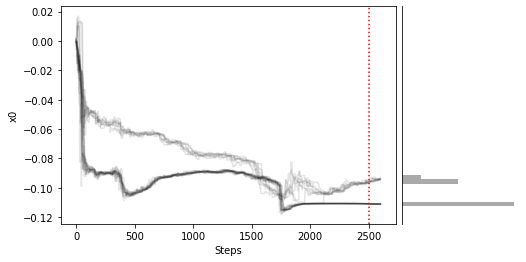

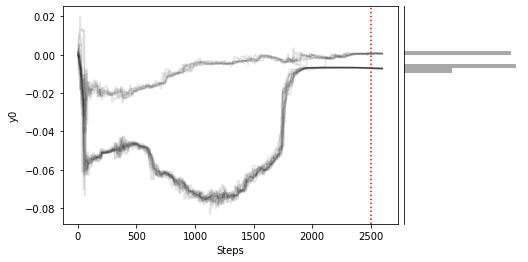

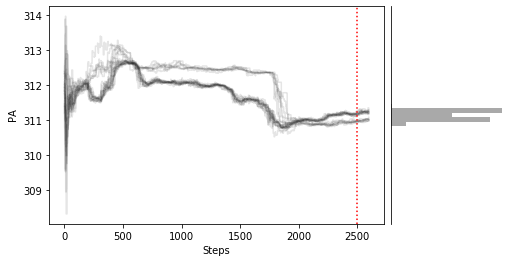

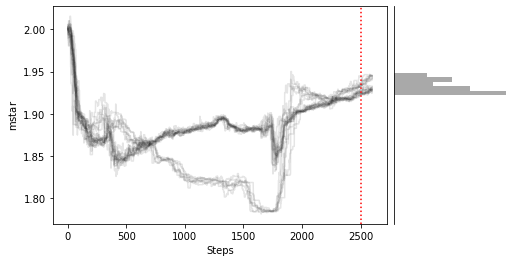

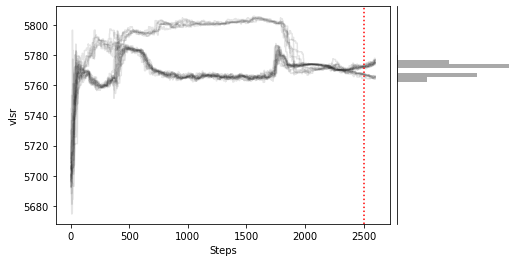

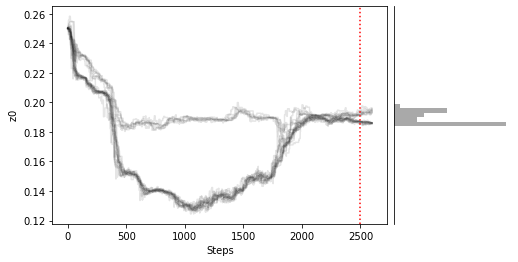

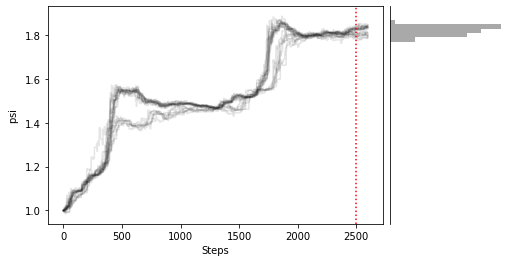

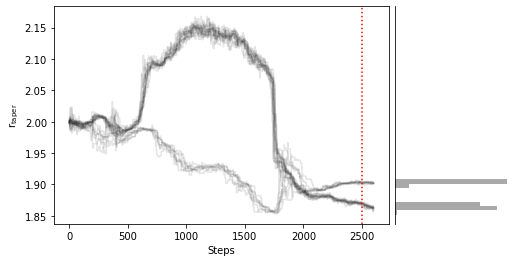

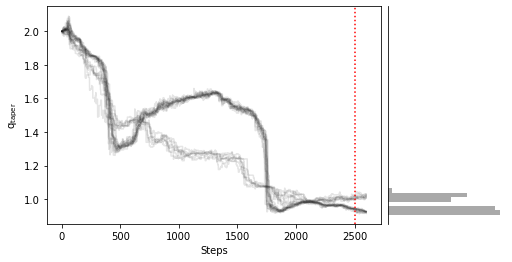

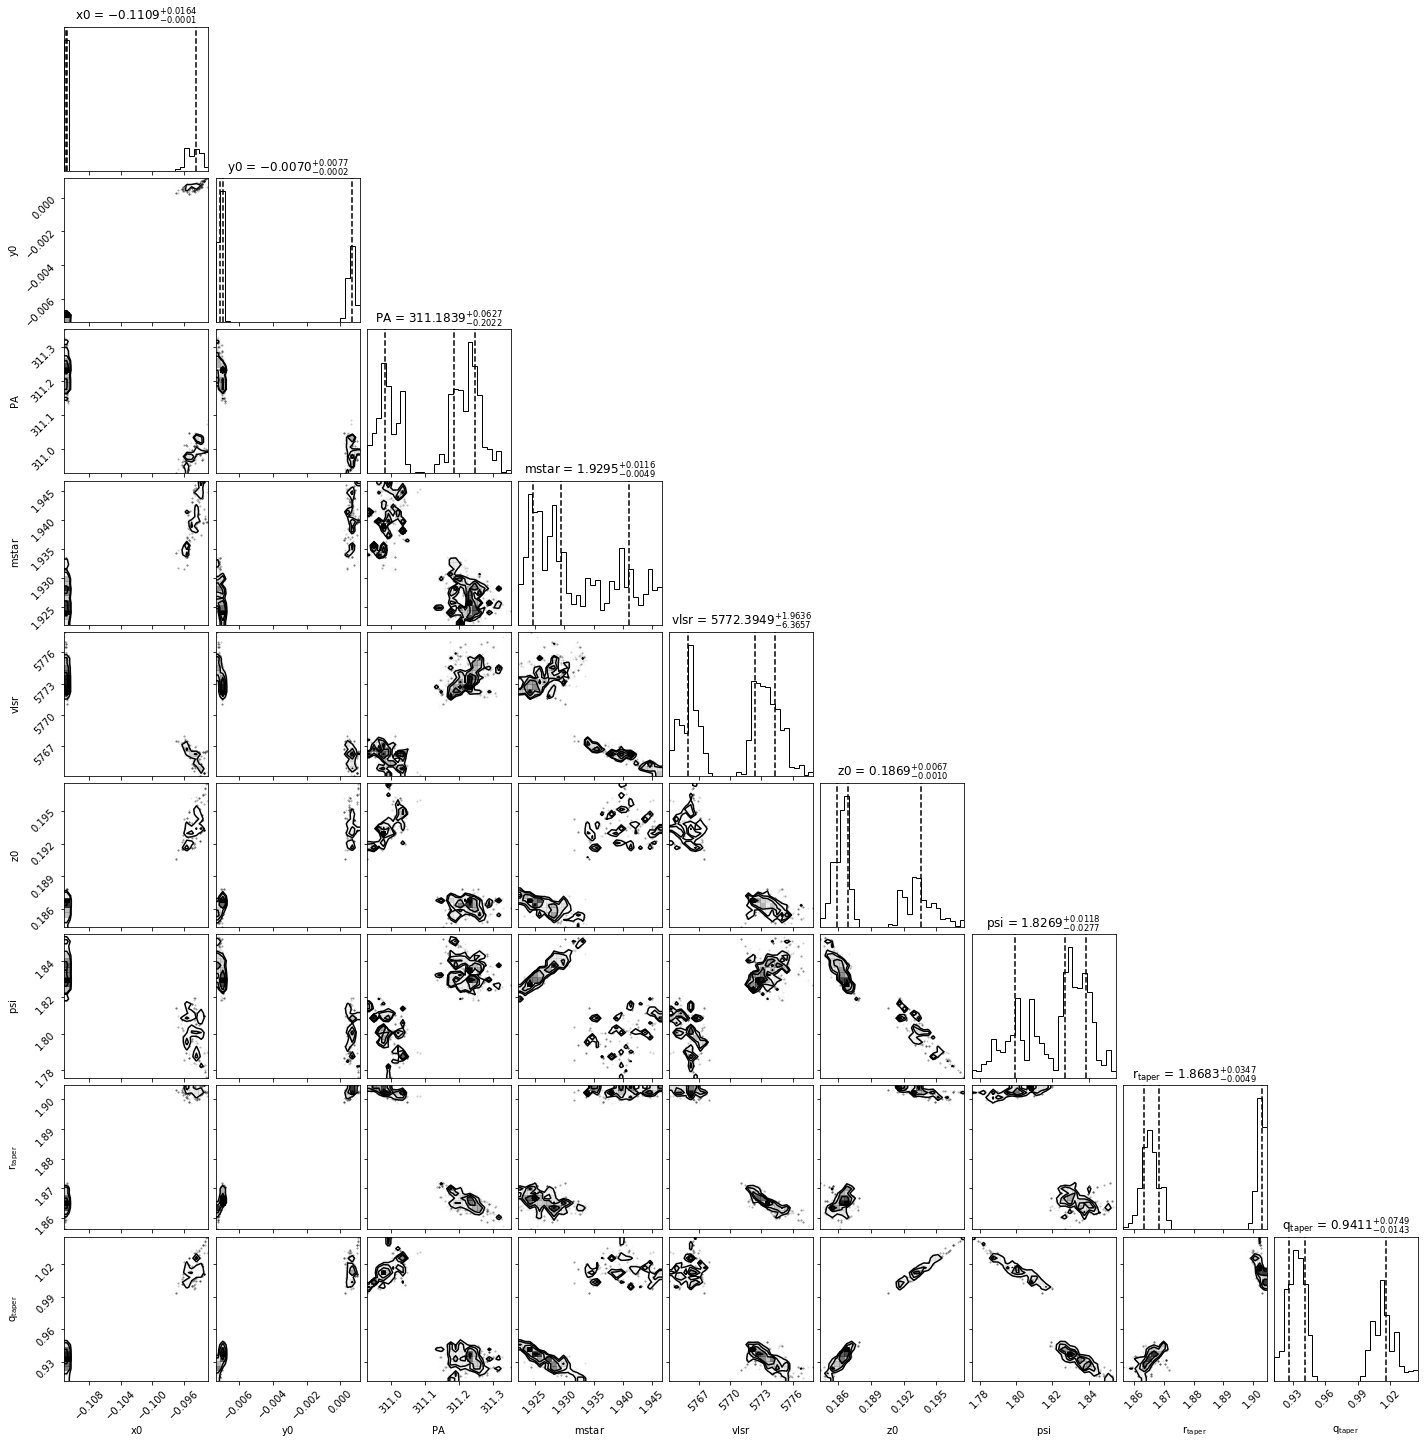

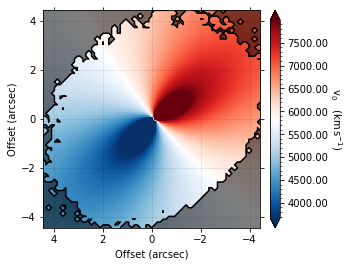

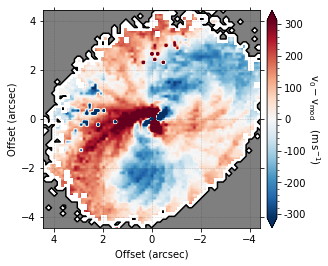

In [6]:
# Define a standard geometrically thin dictionary.

params = {}
params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4

p0 = [0.0, 0.0, 312., 2.0, 5.7e3]

params['inc'] = 46.7    
params['dist'] = 101.0

# Include elevated emission surface parameters.

params['z0'] = 5
params['psi'] = 6
params['r_taper'] = 7
params['q_taper'] = 8

p0 += [0.25, 1.0, 2.0, 2.0]

# Run the MCMC.

from multiprocessing import Pool

with Pool() as pool:
    samples = cube.fit_map(p0=p0, params=params, nwalkers=20, nburnin=2500,
                           nsteps=100, pool=pool, optimize=False, niter=1)

Things are not looking great here: the walkers clearly have not converged and we see large, systematic residuals. The 

### Residuals

In the residual map you can see a lot of structure. The most prominent are the positive and negative residuals along the major axis which are due to the pressure support of the gas disk resulting in slower rotation at larger radii. This was another reason why the `r_max` value was set smaller than one would typically expect.

There's also spoke-like features around the disk, due to the channelization of the data. Although the model is able to create a continuous rotation pattern, the accuracy of the `v0` maps is limited by the velocity resolution of the data.

Finally, there are some arc like structures in the disk. There's one centered at $(-0.5^{\prime\prime},\,1.5^{\prime\prime})$, roughly at the location of the velocity kink reported by [Pinte et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...860L..13P/abstract). If this is what such a kink looks like in residuals, perhaps there are many more planets in the disk...

## Plotting the Emission Surface

Now that we have constrained the emission surface (on the assumption that out model is a reasonable replication of the true source structure), we can overplot the emission surface to check what that looks like.

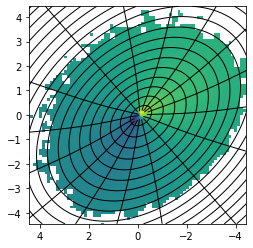

In [7]:
cube.plot_model_surface(samples, params, plot_surface_kwargs=dict(fill='self.data'))